<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/EasyXAI_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire occurence / susceptibility prediction

### Imports

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.image as mpimg

In [3]:
import random
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
from IPython.display import Image, display
import matplotlib as mpl

### 1. Load data

In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-2.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle-2.json': No such file or directory
ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadehsan000/healthcare-dataset-2019-2024                  Healthcare Dataset (2019-2024)                       3MB  2024-08-09 17:52:25           3294         75  1.0              
berkayalan/paris-2024-olympics-medals                          Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           1308         33  1.0              
parthdande/movies-box-office-collection-data-2000-2024         Movies Box Office Collection Data 2000-2024        161KB  2024-08-15 07:31:34    

In [6]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.44G/1.45G [00:27<00:00, 67.7MB/s]
100% 1.45G/1.45G [00:27<00:00, 57.1MB/s]


In [ ]:
  ! unzip wildfire-prediction-dataset.zip

In [5]:
def load_data(subset):
  return tf.keras.utils.image_dataset_from_directory(
    f"/content/{subset}",
    labels="inferred",
    #label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
    )

In [8]:
train_data = load_data("train")
test_data = load_data("test")
valid_data = load_data("valid")

Found 30250 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


In [9]:

# Set the directory paths
train_dir = '/content/train'  # Adjust this path if necessary
valid_dir = '/content/valid'  # Adjust this path if necessary

# Prepare lists to store images and labels
x_train = []
y_train = []
x_valid = []
y_valid = []

# Function to load and process images
def load_dataset(dir_path, x_list, y_list):
    for direct in os.listdir(dir_path):
        print(f"Loading dataset from directory: {direct}")
        class_dir = os.path.join(dir_path, direct)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (32, 32))  # Resize image
                img = img / 255.0  # Normalize image
                x_list.append(img)
                y_list.append(direct)  # Add the label (directory name as class)
            else:
                print(f"Could not read image: {img_path}")

# Load training data
load_dataset(train_dir, x_train, y_train)

# Load validation data
load_dataset(valid_dir, x_valid, y_valid)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_valid.shape}")


Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Training data shape: (30250, 32, 32, 3)
Validation data shape: (6300, 32, 32, 3)


In [10]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_valid_onehot = onehot_encoder.transform(y_valid_encoded.reshape(-1, 1))

print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Validation labels shape: {y_valid_onehot.shape}")

Training labels shape: (30250, 2)
Validation labels shape: (6300, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 2. Preprocess data

In [10]:
def resize(subset, height, width):
  return subset.map(lambda x,y: (tf.keras.layers.Resizing(height, width)(x), y))

resized_train_data = resize(train_data, 32,32)
resized_test_data = resize(test_data, 32,32)
resized_valid_data = resize(valid_data, 32,32)

In [12]:
def normalize(subset):
  return subset.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))

normalized_train_data = normalize(resized_train_data)
normalized_test_data = normalize(resized_test_data)
normalized_valid_data = normalize(resized_valid_data)

In [15]:
for image, label in train_data.take(1):
    print("Label:", label.numpy())

Label: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1]


In [17]:
def one_hot(subset):
  return subset.map(lambda x,y: (x, tf.one_hot(y,2)))

one_hot_train_data = one_hot(normalized_train_data)
one_hot_test_data = one_hot(normalized_test_data)
one_hot_valid_data = one_hot(normalized_valid_data)

In [18]:
for image, one_hot_label in one_hot_train_data.take(1):
    print("One-Hot Label:", one_hot_label.numpy())

One-Hot Label: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### 2. Investigate data

In [12]:
class_names = train_data.class_names
i = 0
for class_name in class_names:
  i += 1
  print(f"Class Label {i}: {class_name}")

NameError: name 'train_data' is not defined

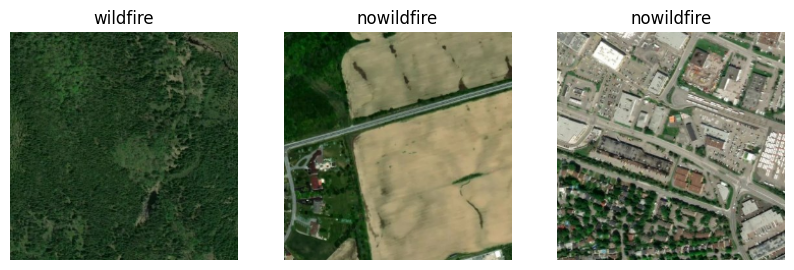

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 3. Model

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
from tensorflow.keras import backend as K
K.clear_session()

In [44]:
model = tf.keras.models.load_model("/content/Wildfirepredictionmodel.keras")

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,205,000 (12.23 MB)

 Trainable params: 1,068,290 (4.08 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2,136,582 (8.15 MB)

In [15]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [16]:
history = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    epochs=10,
    batch_size=32
)


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 170s 178ms/step - accuracy: 0.8960 - loss: 0.3059 - val_accuracy: 0.8151 - val_loss: 0.8605
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 211s 188ms/step - accuracy: 0.9302 - loss: 0.1830 - val_accuracy: 0.9524 - val_loss: 0.1357
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 231s 219ms/step - accuracy: 0.9442 - loss: 0.1506 - val_accuracy: 0.9411 - val_loss: 0.1591
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 241s 197ms/step - accuracy: 0.9491 - loss: 0.1360 - val_accuracy: 0.9497 - val_loss: 0.1372
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 180s 191ms/step - accuracy: 0.9564 - loss: 0.1155 - val_accuracy: 0.9497 - val_loss: 0.1581
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 226s 216ms/step - accuracy: 0.9598 - loss: 0.1073 - val_accuracy: 0.8919 - val_loss: 0.3227
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 151s 160ms/step - accuracy: 0.9632 - loss: 0.1009 - val_accuracy: 0.9322 - val_loss: 0.2143
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 200s 158ms/step - accuracy: 0.9689 -

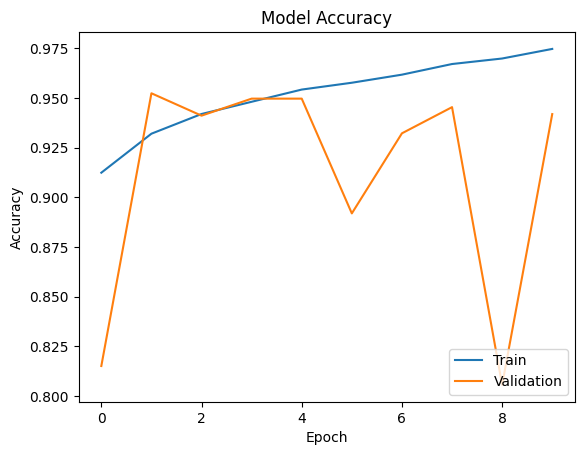

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

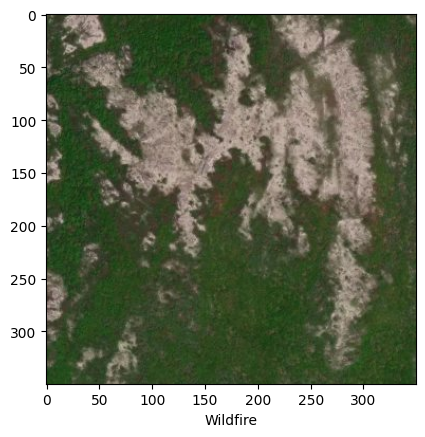

In [16]:
test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
plt.xlabel("Wildfire")
plt.show()

In [17]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(32,32))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,32,32,3)
test_arr.append(test_image)

In [50]:
model.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


array([[0.00515435, 0.9948456 ]], dtype=float32)

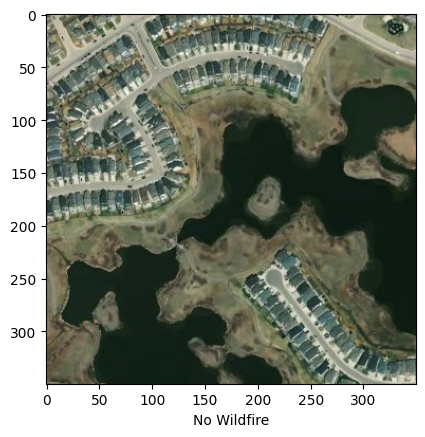

In [21]:
test_img_path = "/content/test/nowildfire/-113.91777,50.901087.jpg"
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
plt.xlabel("No Wildfire")
plt.show()

In [22]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(32,32))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,32,32,3)
test_arr.append(test_image)

In [23]:
model.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[0.99516857, 0.00483152]], dtype=float32)

In [24]:
model.save('Wildfirepredictionmodel.keras')

### GradCAM

#### Functional model test

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense

# Define the input
input_layer = Input(shape=(32, 32, 3))

# Add the first Conv2D layer
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)

# Add the second Conv2D layer
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Add MaxPooling2D layer
x = MaxPooling2D(pool_size=(2, 2))(x)

# Add BatchNormalization layer
x = BatchNormalization()(x)

# Flatten the tensor before passing to Dense layers
x = Flatten()(x)

# Add Dropout layer
x = Dropout(0.2)(x)

# Add Dense layer
x = Dense(64, activation='relu')(x)

# Add the final Dense layer with softmax activation for binary classification
# Note: For binary classification, usually 'sigmoid' is used with one output neuron.
output_layer = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,068,418 (4.08 MB)

 Trainable params: 1,068,290 (4.08 MB)

 Non-trainable params: 128 (512.00 B)

In [54]:
history = model.fit(
    x_train, y_train_onehot,  # Training data and labels
    validation_data=(x_valid, y_valid_onehot),  # Validation data and labels
    epochs=10,  # Number of epochs
    batch_size=32  # Batch size
)


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 163s 170ms/step - accuracy: 0.9049 - loss: 0.2782 - val_accuracy: 0.9387 - val_loss: 0.1825
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 153s 162ms/step - accuracy: 0.9355 - loss: 0.1721 - val_accuracy: 0.9344 - val_loss: 0.1567
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 204s 164ms/step - accuracy: 0.9436 - loss: 0.1505 - val_accuracy: 0.8976 - val_loss: 0.2600
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 161s 170ms/step - accuracy: 0.9533 - loss: 0.1278 - val_accuracy: 0.9486 - val_loss: 0.1413
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 195s 163ms/step - accuracy: 0.9613 - loss: 0.1079 - val_accuracy: 0.8595 - val_loss: 0.4505
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 205s 166ms/step - accuracy: 0.9656 - loss: 0.0942 - val_accuracy: 0.9338 - val_loss: 0.1880
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 199s 163ms/step - accuracy: 0.9697 - loss: 0.0829 - val_accuracy: 0.9451 - val_loss: 0.1459
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 205s 166ms/step - accuracy: 0.9745 -

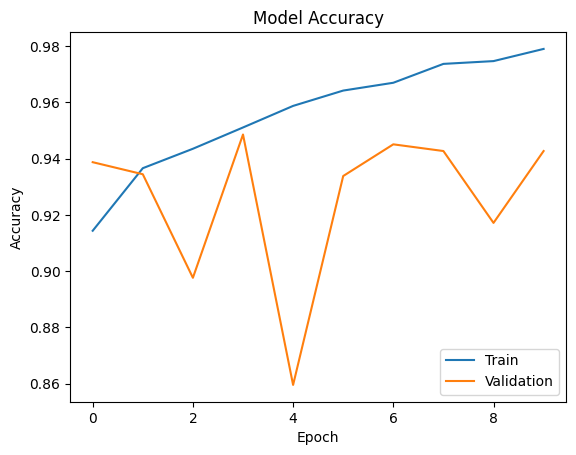

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

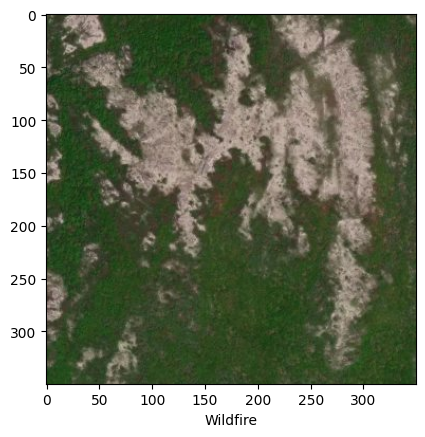

In [81]:
test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
plt.xlabel("Wildfire")
plt.show()

In [82]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(32,32))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,32,32,3)
test_arr.append(test_image)

In [86]:
# Load the image using cv2
image = cv2.imread("/content/test/wildfire/-59.03238,51.85132.jpg")

# Get the dimensions of the image
height, width, channels = image.shape

# Print the resolution
print(f"Image resolution: {width} x {height}")

Image resolution: 350 x 350


In [87]:

def find_min_resolution(image_folder):
    min_width = float('inf')
    min_height = float('inf')

    # Loop over all files in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):  # Include common image file formats
            image_path = os.path.join(image_folder, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Check if image was loaded successfully
            if image is not None:
                height, width, _ = image.shape  # Get the dimensions (height, width, channels)

                # Update min_width and min_height
                if width < min_width:
                    min_width = width
                if height < min_height:
                    min_height = height

    return min_width, min_height

# Example usage
image_folder = "/content/train/wildfire"
min_width, min_height = find_min_resolution(image_folder)
print(f"Minimum resolution: {min_width} x {min_height}")

image_folder = "/content/train/nowildfire"
min_width, min_height = find_min_resolution(image_folder)
print(f"Minimum resolution: {min_width} x {min_height}")

Minimum resolution: 350 x 350
Minimum resolution: 350 x 350


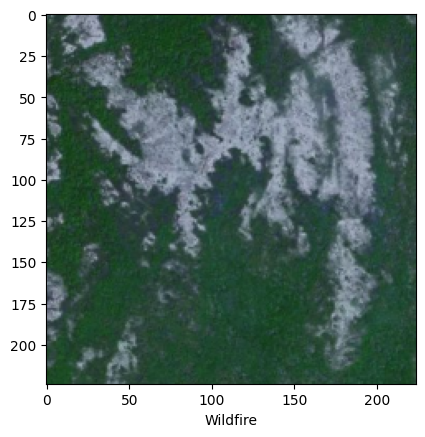

In [90]:
test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
image = mpimg.imread(test_img_path)
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(224,224))
# Plot the image
imgplot = plt.imshow(test_image)
plt.xlabel("Wildfire")
plt.show()

In [58]:
model.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


array([[0.2769336 , 0.72306633]], dtype=float32)

In [59]:
model.save('Wildfirepredictionmodel_functional.keras')

In [62]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [65]:
preds = model.predict(test_image)
i = np.argmax(preds[0])
i # 0 - great model correctly recognize, this is an odd number

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


1

In [73]:
# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_1')
heatmap = icam.compute_heatmap(test_image)
heatmap = cv2.resize(heatmap, (32, 32))

#image = cv2.imread('/content/5.png')
#image = cv2.resize(image, (84, 84))
test_image = np.uint8(255 * (test_image.squeeze() - np.min(test_image.squeeze())) / (np.max(test_image.squeeze()) - np.min(test_image.squeeze())))
print(heatmap.shape, test_image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, test_image, alpha=0.5)

(32, 32) (32, 32, 3)


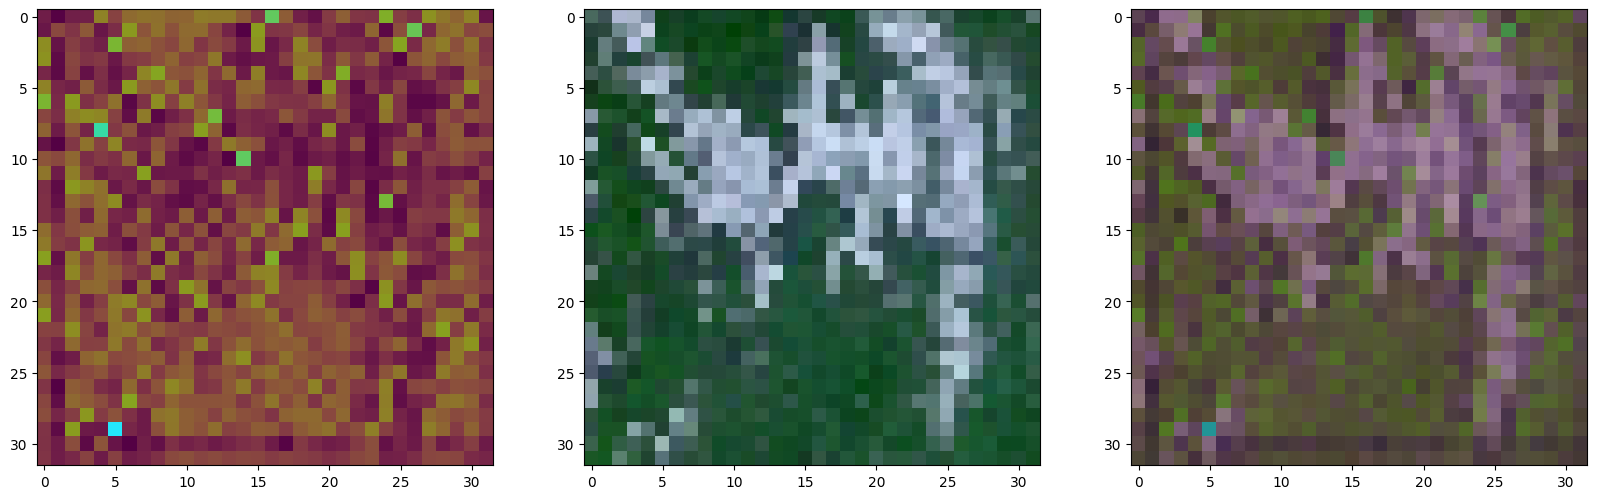

In [74]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(test_image)
ax[2].imshow(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


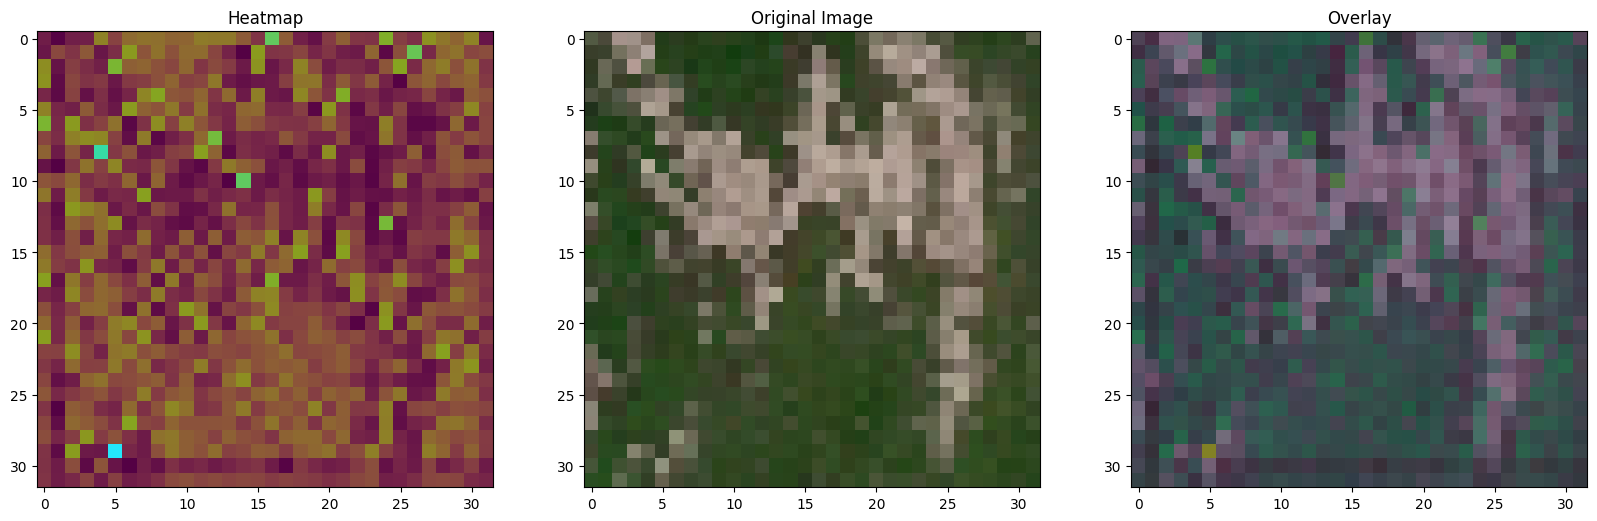

In [77]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# GradCAM class and other necessary imports remain the same.

# Load the image
test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image, (32, 32))

# Preprocess the image for model input
test_image_input = test_image / 255.0
test_image_input = np.expand_dims(test_image_input, axis=0)  # Add batch dimension

# Predict using the model
preds = model.predict(test_image_input)
i = np.argmax(preds[0])

# Initialize GradCAM
icam = GradCAM(model, i, 'conv2d_1')

# Compute the heatmap
heatmap = icam.compute_heatmap(test_image_input)

# Resize heatmap to match the input image size
heatmap = cv2.resize(heatmap, (32, 32))

# Apply a colormap to the heatmap (convert to 3-channel image)
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

# Ensure test_image is in the right format for overlay (uint8 and in the range [0, 255])
test_image_uint8 = np.uint8(test_image)

# Overlay the heatmap on the original image
overlay = cv2.addWeighted(test_image_uint8, 0.6, heatmap_colored, 0.4, 0)

# Plotting the results
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 20)

# Plot the heatmap (colored version)
ax[0].imshow(heatmap_colored)
ax[0].set_title("Heatmap")

# Plot the original image
ax[1].imshow(cv2.cvtColor(test_image_uint8, cv2.COLOR_BGR2RGB))
ax[1].set_title("Original Image")

# Plot the heatmap overlaid on the original image
ax[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
ax[2].set_title("Overlay")

# Display the plots
plt.show()


#### From Scratch keras try

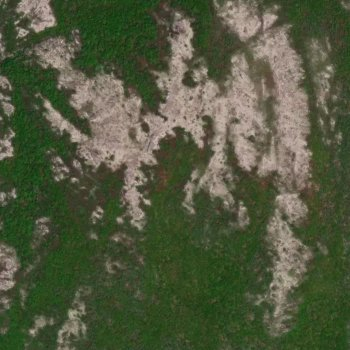

In [48]:
model_builder = keras.applications.xception.Xception
img_size = (32, 32)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_1"

# The local path to our target image
#img_path = keras.utils.get_file(
    #"african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#)
img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))
display(Image(img_path))

In [46]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [41]:
for layer in model.layers:
    print(layer.name)

conv2d
conv2d_1
max_pooling2d
batch_normalization
flatten
dropout
dense
dense_1


In [60]:
from tensorflow.keras import backend as K
import cv2
import numpy as np

# Clear previous session
#K.clear_session()

# Assuming model is already defined and loaded
# Example:
#model = tf.keras.models.load_model("/content/Wildfirepredictionmodel.keras")

# Read and preprocess image
image = cv2.imread("/content/test/wildfire/-59.03238,51.85132.jpg")
image = cv2.resize(image, (32, 32))
image = np.expand_dims(image, axis=0)

# Make sure the model is called before initializing GradCAM
preds = model.predict(image)  # This will initialize the model's graph

# Get the class index for the prediction
i = np.argmax(preds[0])

# Now initialize GradCAM
icam = GradCAM(model, i, 'conv2d_1')

# Compute the heatmap using GradCAM
heatmap = icam.compute_heatmap(image)

# Resize the heatmap to match the image dimensions
heatmap = cv2.resize(heatmap, (32, 32))

# Remove the batch dimension from the input image for visualization
image = np.squeeze(image, axis=0)

# Overlay the heatmap onto the original image
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

# Print shapes for verification
print(heatmap.shape, image.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
(32, 32, 3) (32, 32, 3)


In [61]:
image = cv2.imread("/content/test/wildfire/-59.03238,51.85132.jpg")
image = cv2.resize(image, (32, 32))
# Add a new axis to represent the batch dimension
image = np.expand_dims(image, axis=0)
preds = model.predict(image)
i = np.argmax(preds[0])
icam = GradCAM(model, i, 'conv2d_1')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

# Remove the batch dimension before overlaying
image = np.squeeze(image, axis=0)
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(32, 32) (32, 32, 3)


In [26]:
for layer in model.layers:
    print(layer.name)

conv2d
conv2d_1
max_pooling2d
batch_normalization
flatten
dropout
dense
dense_1


### Debuggin

In [104]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    weights = layer.get_weights()  # This returns the weights and biases of the layer
    if weights:  # Some layers might not have weights (e.g., pooling layers)
        print(f"Weights: {weights[0].shape}")
        if len(weights) > 1:
            print(f"Biases: {weights[1].shape}")
    print("\n")

Layer Name: conv2d
Weights: (3, 3, 3, 32)
Biases: (32,)


Layer Name: conv2d_1
Weights: (3, 3, 32, 64)
Biases: (64,)


Layer Name: max_pooling2d


Layer Name: batch_normalization
Weights: (64,)
Biases: (64,)


Layer Name: flatten


Layer Name: dropout


Layer Name: dense
Weights: (16384, 64)
Biases: (64,)


Layer Name: dense_1
Weights: (64, 2)
Biases: (2,)




### Guided GradCAM

In [ ]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

#### Guided Backpropagation

In [ ]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [ ]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [ ]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [ ]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [ ]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

In [ ]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

#### Guided Backpropagation combined with GradCAM

In [ ]:
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [ ]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [ ]:
gb = GuidedBackprop(model, "cond2d_1")

In [ ]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [ ]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

In [ ]:
plt.imshow(saliency_map)

### Fine Tune Resnet

#### Model Building

In [9]:

# Set the directory paths
train_dir = '/content/train'  # Adjust this path if necessary
valid_dir = '/content/valid'  # Adjust this path if necessary

# Prepare lists to store images and labels
x_train = []
y_train = []
x_valid = []
y_valid = []

# Function to load and process images
def load_dataset(dir_path, x_list, y_list):
    for direct in os.listdir(dir_path):
        print(f"Loading dataset from directory: {direct}")
        class_dir = os.path.join(dir_path, direct)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize image
                img = img / 255.0  # Normalize image
                x_list.append(img)
                y_list.append(direct)  # Add the label (directory name as class)
            else:
                print(f"Could not read image: {img_path}")

# Load training data
load_dataset(train_dir, x_train, y_train)

# Load validation data
load_dataset(valid_dir, x_valid, y_valid)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_valid.shape}")


Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Training data shape: (30250, 64, 64, 3)
Validation data shape: (6300, 64, 64, 3)


In [10]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_valid_onehot = onehot_encoder.transform(y_valid_encoded.reshape(-1, 1))

print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Validation labels shape: {y_valid_onehot.shape}")

Training labels shape: (30250, 2)
Validation labels shape: (6300, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model, pretrained on ImageNet, excluding the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers to retain the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(64, activation='relu')(x)  # Add a Dense layer
x = Dropout(0.5)(x)

# Output layer for binary classification
output_layer = Dense(2, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
#model.summary()

# Train the model
#history = model.fit(train_data, epochs=20, validation_data=val_data)
#history = model.fit(
    #x_train, y_train_onehot,
    #validation_data=(x_valid, y_valid_onehot),
    #epochs=15,
    #batch_size=32
#)

# Unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Continue fine-tuning the model
history_finetune = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    epochs=15,
    batch_size=32
)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,718,978 (90.48 MB)

 Trainable params: 4,596,930 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1422s 1s/step - accuracy: 0.7249 - loss: 0.5962 - val_accuracy: 0.8708 - val_loss: 0.3205
Epoch 2/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1396s 1s/step - accuracy: 0.8412 - loss: 0.3827 - val_accuracy: 0.8838 - val_loss: 0.2906
Epoch 3/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1344s 1s/step - accuracy: 0.8564 - loss: 0.3454 - val_accuracy: 0.8887 - val_loss: 0.2796
Epoch 4/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1443s 1s/step - accuracy: 0.8707 - loss: 0.3186 - val_accuracy: 0.8952 - val_loss: 0.2771
Epoch 5/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1427s 2s/step - accuracy: 0.8729 - loss: 0.3101 - val_accuracy: 0.8981 - val_loss: 0.2578
Epoch 6/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1431s 1s/step - accuracy: 0.8816 - loss: 0.2922 - val_accuracy: 0.9035 - val_loss: 0.2595
Epoch 7/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1377s 1s/step - accuracy: 0.8876 - loss: 0.2735 - val_accuracy: 0.8987 - val_loss: 0.2604
Epoch 8/15
946/946 ━━━━━━━━━━━━━━━━━━━━ 1411s 1s/step - accuracy: 0.8863 - loss: 0.2796 - 

In [12]:
model.save('fine_tuned_model.keras')

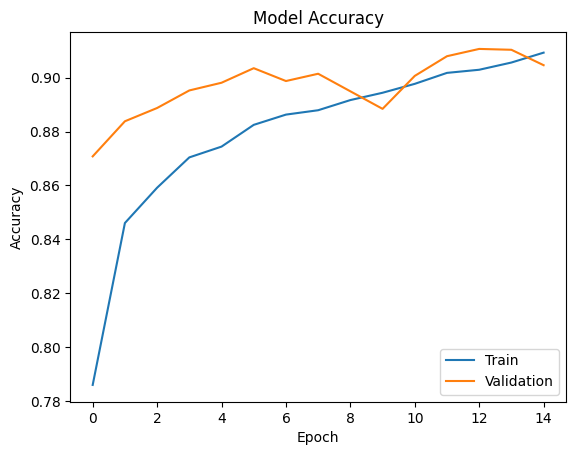

In [14]:
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

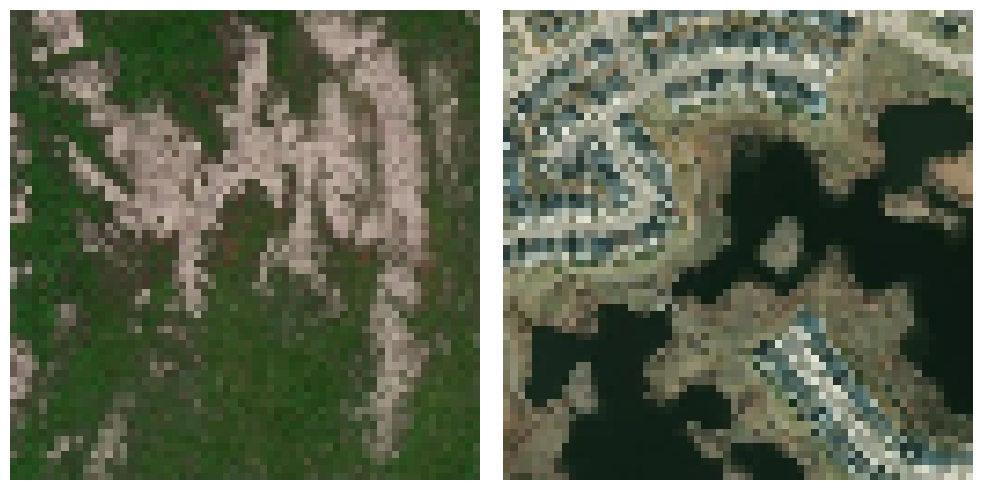

In [19]:

# Load and resize the first image
test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg"
test_image_fire = cv2.imread(test_img_path)
test_image_fire = cv2.resize(test_image_fire, (64, 64))
test_image_fire = cv2.cvtColor(test_image_fire, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Load and resize the second image
test2_img_path = "/content/test/nowildfire/-113.91777,50.901087.jpg"
test_image_nofire = cv2.imread(test2_img_path)
test_image_nofire = cv2.resize(test_image_nofire, (64, 64))
test_image_nofire = cv2.cvtColor(test_image_nofire, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot first image
axes[0].imshow(test_image_fire)
axes[0].set_xlabel("Wildfire")
axes[0].axis('off')  # Turn off axis ticks and labels

# Plot second image
axes[1].imshow(test_image_nofire)
axes[1].set_xlabel("No Wildfire")
axes[1].axis('off')  # Turn off axis ticks and labels

# Show the images
plt.tight_layout()
plt.show()

In [20]:
test_image_fire = test_image_fire / 255.0
test_image_nofire = test_image_nofire / 255.0

# Create a test array with the two images
test_arr = np.array([test_image_fire, test_image_nofire])
model.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


array([[0.22501664, 0.26844212],
       [0.4066909 , 0.07232346]], dtype=float32)

#### GradCAM

In [21]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
preds_fire = model.predict(test_image_fire)
preds_nofire = model.predict(test_image_nofire)
i_fire = np.argmax(preds_fire[0])
i_fire # 1 - great model correctly recognize, this is a wildfire

i_nofire = np.argmax(preds_nofire[0])
i_nofire # 0 - great model correctly recognize, this is not a wildfire

In [ ]:
# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i_fire, 'conv2d_1')
heatmap = icam.compute_heatmap(test_image)
heatmap = cv2.resize(heatmap, (32, 32))

#image = cv2.imread('/content/5.png')
#image = cv2.resize(image, (84, 84))
test_image = np.uint8(255 * (test_image.squeeze() - np.min(test_image.squeeze())) / (np.max(test_image.squeeze()) - np.min(test_image.squeeze())))
print(heatmap.shape, test_image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, test_image, alpha=0.5)

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(test_image)
ax[2].imshow(output)